### **Face and Style Recognition with EfficientNet**
Date: 12.06.2024

---


Student Name: Birkan Cemil Abacı

Id:20070001048


---





##Introduction
In this project, I aimed to build a multi-label image classification model to recognize both the identity and style of celebrity cartoons. I used the **EfficientNet** architecture for state-of-the-art performance in image classification tasks. This report details the methods used, experiments and results obtained during the project.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# helper.py

"""
This module contains custom dataset classes and utility functions for loading, processing,
and evaluating images of celebrities in different caricature styles.

Classes:
1. CelebCariDataset:
   - Loads training/validation images with person and style labels.
   - Supports image transformations.

2. CelebCariTestDataset:
   - Loads test images without labels.
   - Supports image transformations.

Functions:
1. calculate_accuracy:
   - Computes accuracy and average loss for person and style predictions.

2. save_gallery_to_json:
   - Saves gallery embeddings to a JSON file.

3. create_gallery_embeddings:
   - Creates gallery embeddings using a model and dataset.

4. read_gallery_from_json:
   - Reads gallery embeddings from a JSON file.

5. encode_embedding:
   - Encodes an embedding to a base64 string.

6. write_predictions_to_json:
   - Writes predictions to a JSON file.

Usage:
- Import the classes and functions and create dataset instances by specifying the root directory and transformations.
- Use with a DataLoader to iterate through the data.
- Use calculate_accuracy to evaluate model performance.
- Use save_gallery_to_json to save embeddings to a JSON file.
- Use create_gallery_embeddings to generate embeddings from a model and dataset.
- Use read_gallery_from_json to load embeddings from a JSON file.
- Use encode_embedding to encode a tensor to a base64 string.
- Use write_predictions_to_json to save predictions to a JSON file.

Example:
from helper import CelebCariDataset, CelebCariTestDataset, calculate_accuracy, save_gallery_to_json, create_gallery_embeddings, read_gallery_from_json, encode_embedding, write_predictions_to_json
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Training dataset
train_dataset = CelebCariDataset(root_dir='path_to_train_dataset', transform=transform)
train_image, person_label, style_label = train_dataset[0]

# Test dataset
test_dataset = CelebCariTestDataset(root_dir='path_to_test_dataset', transform=transform)
test_image, image_path = test_dataset[0]

# Calculate accuracy
accuracy_person, accuracy_style, avg_loss_person, avg_loss_style = calculate_accuracy(
    predicted_person, predicted_style, person_labels, style_labels, running_loss_person, running_loss_style, total)

# Create and save gallery embeddings
gallery_embeddings = create_gallery_embeddings(model, train_dataset, device)
save_gallery_to_json(gallery_embeddings, 'gallery_embeddings.json')

# Read gallery embeddings from JSON
loaded_gallery_embeddings = read_gallery_from_json('gallery_embeddings.json')

# Encode an embedding
encoded_embedding = encode_embedding(gallery_embeddings['person_name'][0])

# Write predictions to JSON
predictions = [('image1.jpg', torch.tensor([1.0, 2.0, 3.0]), 'style1'), ('image2.jpg', torch.tensor([4.0, 5.0, 6.0]), 'style2')]
write_predictions_to_json(predictions, 'predictions.json')
"""

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import base64
import json
import numpy as np
import torch

class CelebCariDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.person_labels = []
        self.style_labels = []
        self.person_to_index = {}
        self.style_to_index = {}
        self.index_to_person = {}
        self.index_to_style = {}
        self._prepare_dataset()

    def _prepare_dataset(self):
        for person_folder in os.listdir(self.root_dir):
            person_path = os.path.join(self.root_dir, person_folder)
            if os.path.isdir(person_path):
                if person_folder not in self.person_to_index:
                    self.person_to_index[person_folder] = len(self.person_to_index)
                    self.index_to_person[self.person_to_index[person_folder]] = person_folder
                for file_name in os.listdir(person_path):
                    if file_name.endswith(".jpg") or file_name.endswith(".png"):
                        style_name = file_name.split('_')[2]
                        if style_name not in self.style_to_index:
                            self.style_to_index[style_name] = len(self.style_to_index)
                            self.index_to_style[self.style_to_index[style_name]] = style_name
                        self.image_paths.append(os.path.join(person_path, file_name))
                        self.person_labels.append(self.person_to_index[person_folder])
                        self.style_labels.append(self.style_to_index[style_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        person_label = self.person_labels[idx]
        style_label = self.style_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, person_label, style_label

class CelebCariTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, file_name) for file_name in os.listdir(root_dir)
                            if file_name.endswith(".jpg") or file_name.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, image_path

def calculate_accuracy(predicted_person, predicted_style, person_labels, style_labels, running_loss_person, running_loss_style, total):
    """
    Computes accuracy and average loss for person and style predictions.

    Args:
    - predicted_person: Tensor of predicted person labels.
    - predicted_style: Tensor of predicted style labels.
    - person_labels: Tensor of true person labels.
    - style_labels: Tensor of true style labels.
    - running_loss_person: Cumulative loss for person predictions.
    - running_loss_style: Cumulative loss for style predictions.
    - total: Total number of samples.

    Returns:
    - accuracy_person: Accuracy of person predictions.
    - accuracy_style: Accuracy of style predictions.
    - average_loss_person: Average loss for person predictions.
    - average_loss_style: Average loss for style predictions.
    """
    correct_person = (predicted_person == person_labels).sum().item()
    correct_style = (predicted_style == style_labels).sum().item()

    accuracy_person = correct_person / total
    accuracy_style = correct_style / total
    average_loss_person = running_loss_person / total
    average_loss_style = running_loss_style / total

    return accuracy_person, accuracy_style, average_loss_person, average_loss_style

def save_gallery_to_json(gallery_embeddings, file_path):
    gallery_embeddings_encoded = {person: [encode_embedding(torch.tensor(embedding)) for embedding in embeddings]
                                  for person, embeddings in gallery_embeddings.items()}
    with open(file_path, 'w') as f:
        json.dump(gallery_embeddings_encoded, f)



def create_gallery_embeddings(model, dataset, device):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    gallery_embeddings = {}

    with torch.no_grad():
        for inputs, person_labels, _ in dataloader:
            inputs, person_labels = inputs.to(device), person_labels.to(device)
            embeddings, person_outputs, style_outputs = model(inputs)

            for embedding, person_label in zip(embeddings, person_labels):
                person_name = dataset.index_to_person[person_label.item()]
                if person_name not in gallery_embeddings:
                    gallery_embeddings[person_name] = []
                gallery_embeddings[person_name].append(embedding.cpu().numpy())

    return gallery_embeddings

def read_gallery_from_json(file_path):
    """
    Reads gallery embeddings from a JSON file.

    Args:
    - file_path: Path to the JSON file.

    Returns:
    - gallery_embeddings: Dictionary of person names to list of embeddings.
    """
    with open(file_path, 'r') as f:
        gallery_dict = json.load(f)

    gallery_embeddings = {}
    for person_name, embedding_list in gallery_dict.items():
        gallery_embeddings[person_name] = [torch.tensor(np.frombuffer(base64.b64decode(embedding_str), dtype=np.float32)) for embedding_str in embedding_list]

    return gallery_embeddings

def encode_embedding(embedding):
    """
    Encodes an embedding to a base64 string.

    Args:
    - embedding: A tensor representing the embedding.

    Returns:
    - A base64 encoded string of the embedding.
    """
    return base64.b64encode(embedding.cpu().numpy().astype(np.float32).tobytes()).decode('utf-8')


def write_predictions_to_json(predictions, output_json_path):
    """
    Writes predictions to a JSON file.

    Args:
    - predictions: List of tuples containing filename, embedding, and style.
    - output_json_path: Path to the output JSON file.

    Returns:
    None
    """
    predictions_json = []
    for filename, embedding, style in predictions:
        embedding_str = encode_embedding(embedding)
        predictions_json.append({
            'filename': filename,
            'embedding': embedding_str,
            'style': style
        })

    with open(output_json_path, 'w') as file:
        json.dump(predictions_json, file, indent=4)


In [ ]:
# Define the dataset and dataloaders with data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_path = '/content/drive/MyDrive/New_folder/train'
test_dataset_path =  '/content/drive/MyDrive/New_folder/test'
validation_dataset_path = '/content/drive/MyDrive/New_folder/validation'

# Load datasets
train_dataset = CelebCariDataset(root_dir= train_dataset_path, transform=train_transform)
val_dataset = CelebCariDataset(root_dir=validation_dataset_path, transform=transform)
test_dataset = CelebCariTestDataset(root_dir= test_dataset_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F

def cosine_similarity(embedding1, embedding2, device='cpu'):
    embedding1 = embedding1.clone().detach().to(device)
    embedding2 = embedding2.clone().detach().to(device)
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))


def find_most_similar(embedding, gallery_embeddings):
    max_similarity = -1
    most_similar_person = None
    for person, embeddings in gallery_embeddings.items():
        for gallery_embedding in embeddings:
            similarity = cosine_similarity(embedding, gallery_embedding).item()
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_person = person
    return most_similar_person, max_similarity

def add_new_person_to_gallery(person_name, embedding, gallery_embeddings, gallery_path):
    if person_name not in gallery_embeddings:
        gallery_embeddings[person_name] = []
    gallery_embeddings[person_name].append(embedding.numpy())
    save_gallery_to_json(gallery_embeddings, gallery_path)


In [ ]:
pip install efficientnet-pytorch


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet

class MultiLabelModel(nn.Module):
    def __init__(self, num_classes_identity, num_classes_style):
        super(MultiLabelModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.fc_identity = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_identity)
        )
        self.fc_style = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_style)
        )

    def forward(self, x):
        features = self.backbone(x)
        identity_output = self.fc_identity(features)
        style_output = self.fc_style(features)
        return features, identity_output, style_output

# Number of classes for identity and style
num_classes_identity = 20
num_classes_style = 6

# Instantiate the model
model = MultiLabelModel(num_classes_identity, num_classes_style)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Loaded pretrained weights for efficientnet-b0


MultiLabelModel(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePa

In [ ]:
# Define the loss function and optimizer with higher weight decay
criterion_identity = nn.CrossEntropyLoss()
criterion_style = nn.CrossEntropyLoss()

def joint_loss(identity_output, style_output, identity_labels, style_labels, weight=0.5):
    loss_identity = criterion_identity(identity_output, identity_labels)
    loss_style = criterion_style(style_output, style_labels)
    return weight * loss_identity + (1 - weight) * loss_style

# Optimizer with higher weight decay and lower learning rate
optimizer = optim.Adam([
    {'params': model.fc_identity.parameters()},
    {'params': model.fc_style.parameters()}
], lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 12
patience = 10

In [ ]:
# Training loop with early stopping and tracking
best_model_wts = model.state_dict()
best_loss = float('inf')
early_stopping_counter = 0

# Lists to store the loss and accuracy values
train_losses, val_losses = [], []
train_identity_losses, val_identity_losses = [], []
train_style_losses, val_style_losses = [], []
train_identity_accuracies, val_identity_accuracies = [], []
train_style_accuracies, val_style_accuracies = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_loss_identity = 0.0
        running_loss_style = 0.0
        correct_identity = 0
        correct_style = 0
        total = 0

        for inputs, identity_labels, style_labels in dataloader:
            inputs = inputs.to(device)
            identity_labels = identity_labels.to(device)
            style_labels = style_labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                features, identity_output, style_output = model(inputs)
                loss = joint_loss(identity_output, style_output, identity_labels, style_labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_loss_identity += criterion_identity(identity_output, identity_labels).item() * inputs.size(0)
            running_loss_style += criterion_style(style_output, style_labels).item() * inputs.size(0)
            total += inputs.size(0)

            _, predicted_identity = torch.max(identity_output, 1)
            _, predicted_style = torch.max(style_output, 1)

            correct_identity += (predicted_identity == identity_labels).sum().item()
            correct_style += (predicted_style == style_labels).sum().item()

        epoch_loss = running_loss / total
        epoch_loss_identity = running_loss_identity / total
        epoch_loss_style = running_loss_style / total

        accuracy_identity = correct_identity / total
        accuracy_style = correct_style / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_identity_losses.append(epoch_loss_identity)
            train_style_losses.append(epoch_loss_style)
            train_identity_accuracies.append(accuracy_identity)
            train_style_accuracies.append(accuracy_style)
        else:
            val_losses.append(epoch_loss)
            val_identity_losses.append(epoch_loss_identity)
            val_style_losses.append(epoch_loss_style)
            val_identity_accuracies.append(accuracy_identity)
            val_style_accuracies.append(accuracy_style)

        print(f'{phase} Loss: {epoch_loss:.4f}')
        print(f'{phase} Identity Loss: {epoch_loss_identity:.4f}')
        print(f'{phase} Style Loss: {epoch_loss_style:.4f}')
        print(f'{phase} Identity Accuracy: {accuracy_identity:.4f}')
        print(f'{phase} Style Accuracy: {accuracy_style:.4f}')

        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, 'best_model.pth')
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

    scheduler.step()

    if early_stopping_counter >= patience:
        print("Early stopping")
        break


Epoch 0/11
----------
train Loss: 1.3900
train Identity Loss: 1.6275
train Style Loss: 1.1525
train Identity Accuracy: 0.5554
train Style Accuracy: 0.6176
val Loss: 3.0200
val Identity Loss: 3.2303
val Style Loss: 2.8097
val Identity Accuracy: 0.0208
val Style Accuracy: 0.1625
Epoch 1/11
----------
train Loss: 0.6302
train Identity Loss: 0.6270
train Style Loss: 0.6334
train Identity Accuracy: 0.8368
train Style Accuracy: 0.7824
val Loss: 3.7573
val Identity Loss: 4.5655
val Style Loss: 2.9492
val Identity Accuracy: 0.0042
val Style Accuracy: 0.1167
Epoch 2/11
----------
train Loss: 0.4785
train Identity Loss: 0.4768
train Style Loss: 0.4802
train Identity Accuracy: 0.8618
train Style Accuracy: 0.8436
val Loss: 4.5110
val Identity Loss: 5.3063
val Style Loss: 3.7158
val Identity Accuracy: 0.0042
val Style Accuracy: 0.0583
Epoch 3/11
----------
train Loss: 0.4378
train Identity Loss: 0.4016
train Style Loss: 0.4740
train Identity Accuracy: 0.8858
train Style Accuracy: 0.8466
val Loss: 4

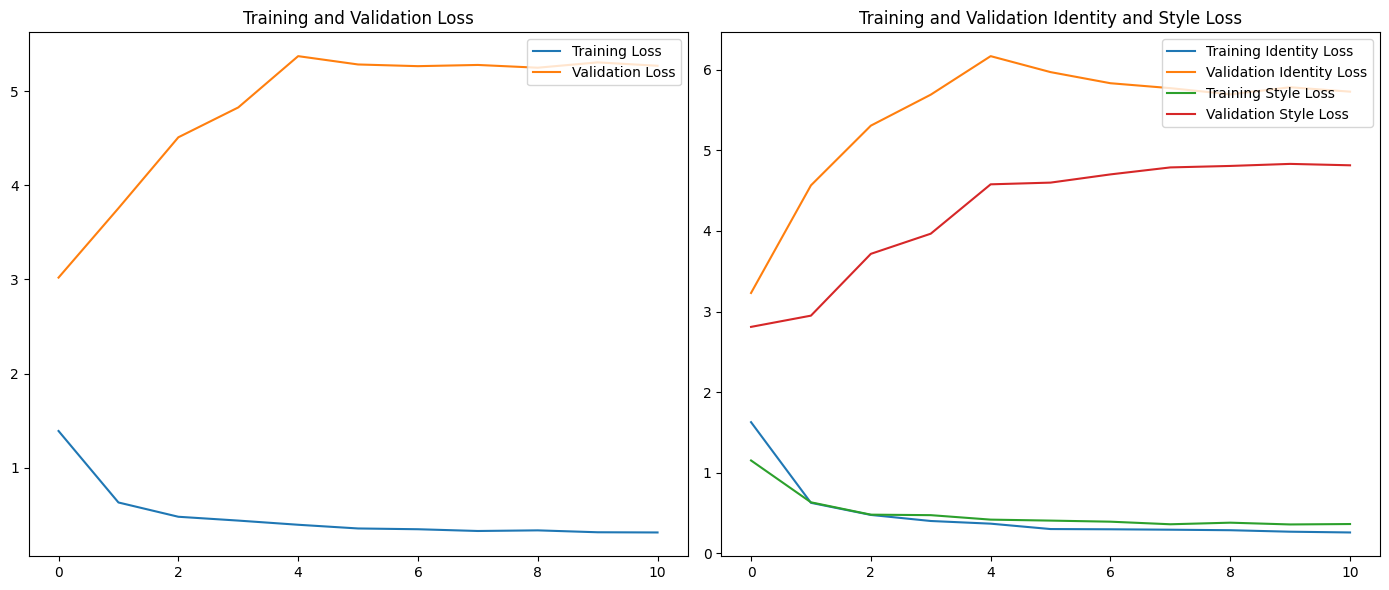

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

# Plotting the tracked metrics
epochs_range = range(num_epochs)
# Adjusting the lengths of epochs_range and metrics if needed
min_length = min(len(epochs_range), len(train_losses), len(val_losses),
                 len(train_identity_losses), len(val_identity_losses),
                 len(train_style_losses), len(val_style_losses),
                 len(train_identity_accuracies), len(val_identity_accuracies),
                 len(train_style_accuracies), len(val_style_accuracies))

# Truncate all lists to the minimum length
epochs_range = epochs_range[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_identity_losses = train_identity_losses[:min_length]
val_identity_losses = val_identity_losses[:min_length]
train_style_losses = train_style_losses[:min_length]
val_style_losses = val_style_losses[:min_length]
train_identity_accuracies = train_identity_accuracies[:min_length]
val_identity_accuracies = val_identity_accuracies[:min_length]
train_style_accuracies = train_style_accuracies[:min_length]
val_style_accuracies = val_style_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_identity_losses, label='Training Identity Loss')
plt.plot(epochs_range, val_identity_losses, label='Validation Identity Loss')
plt.plot(epochs_range, train_style_losses, label='Training Style Loss')
plt.plot(epochs_range, val_style_losses, label='Validation Style Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Identity and Style Loss')

plt.tight_layout()
plt.show()


Here I realized that it is ***already normal*** that these validation **values** are bad. Because our images are actually completely different in the test set. In fact, the data we trained is not in the test set. So from here on, my focus was completely on gallery saving and face embedding.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

# Create and Save Gallery Embeddings Using the Validation Dataset
train_gallery = create_gallery_embeddings(model,train_dataset, device)
save_gallery_to_json(train_gallery, 'gallery_embeddings.json')


In [ ]:
def evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device, similarity_threshold=0.5):
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (validation set)
    model.eval()
    probe_embeddings = {}
    with torch.no_grad():
        for images, person_labels, _ in DataLoader(val_dataset, batch_size=32, shuffle=False):
            images = images.to(device)
            embeddings, _, _ = model(images)
            for embedding, person_label in zip(embeddings, person_labels):
                person_name = val_dataset.index_to_person[person_label.item()]
                if person_name not in probe_embeddings:
                    probe_embeddings[person_name] = []
                probe_embeddings[person_name].append(embedding.cpu())

    print(f"Created probe embeddings: {len(probe_embeddings)} persons")
    total_val_images = sum(len(embeds) for embeds in probe_embeddings.values())
    print(f"Total validation images processed: {total_val_images}")

    # Ensure that we have the same number of images for validation and embedding creation
    all_probe_embeddings = []
    all_probe_labels = []
    for person_name, embeddings in probe_embeddings.items():
        all_probe_embeddings.extend(embeddings)
        all_probe_labels.extend([person_name] * len(embeddings))

    all_probe_tensors = torch.stack(all_probe_embeddings)
    probe_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in probe_embeddings.values()])
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    # Create a mapping from person names to indices
    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}

    # Add an "unknown" category
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    # Determine predicted labels and handle unknown faces
    predicted_indices = []
    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        person_name = list(probe_embeddings.keys())[i]
        print(f"Person: {person_name}, Max Similarity: {max_similarity}")
        if max_similarity < similarity_threshold:
            predicted_indices.append(len(person_to_idx))  # Use new index for new person
            if person_name not in loaded_gallery_embeddings:
                print(f"Adding {person_name} to gallery")
                loaded_gallery_embeddings[person_name] = probe_embeddings[person_name]
                person_to_idx[person_name] = len(person_to_idx)
                idx_to_person[len(idx_to_person)] = person_name
        else:
            predicted_indices.append(torch.argmax(similarities).item())

    # True indices based on the probe set
    true_indices = []
    for person_name in all_probe_labels:
        if person_name in person_to_idx:
            person_idx = person_to_idx[person_name]
        else:
            person_idx = len(person_to_idx)  # Assign new index if not found
            person_to_idx[person_name] = person_idx
            idx_to_person[person_idx] = person_name
            loaded_gallery_embeddings[person_name] = probe_embeddings[person_name]
            print(f"Added {person_name} to gallery as part of true_indices")
        true_indices.append(person_idx)

    # Save updated gallery
    save_gallery_to_json(loaded_gallery_embeddings, gallery_json_path)
    print(f"Updated gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    if len(predicted_indices) != len(true_indices):
        print(f"Warning: Length mismatch - Predicted: {len(predicted_indices)}, True: {len(true_indices)}")
        min_length = min(len(predicted_indices), len(true_indices))
        predicted_indices = predicted_indices[:min_length]
        true_indices = true_indices[:min_length]

    accuracy = (torch.tensor(predicted_indices) == torch.tensor(true_indices)).float().mean().item()
    print(f'Validation Set Accuracy: {accuracy:.4f}')



    # Visualization
    # Convert indices to person names
    true_labels = [idx_to_person[idx] for idx in true_indices]
    predicted_labels = [idx_to_person[idx] for idx in predicted_indices]

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(idx_to_person.values()))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_person.values(), yticklabels=idx_to_person.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()



Loaded gallery embeddings: 12 persons
Created probe embeddings: 4 persons
Total validation images processed: 240
Person: cavill, Max Similarity: 0.8674151301383972
Person: verstappen, Max Similarity: 0.8443179130554199
Person: rihanna, Max Similarity: 0.8361270427703857
Person: lawrance, Max Similarity: 0.8944171071052551
Added cavill to gallery as part of true_indices
Added verstappen to gallery as part of true_indices
Added rihanna to gallery as part of true_indices
Added lawrance to gallery as part of true_indices


<ipython-input-96-a2c5e8beee8a>:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gallery_embeddings_encoded = {person: [encode_embedding(torch.tensor(embedding)) for embedding in embeddings]


Updated gallery embeddings: 16 persons
Validation Set Accuracy: 0.0000


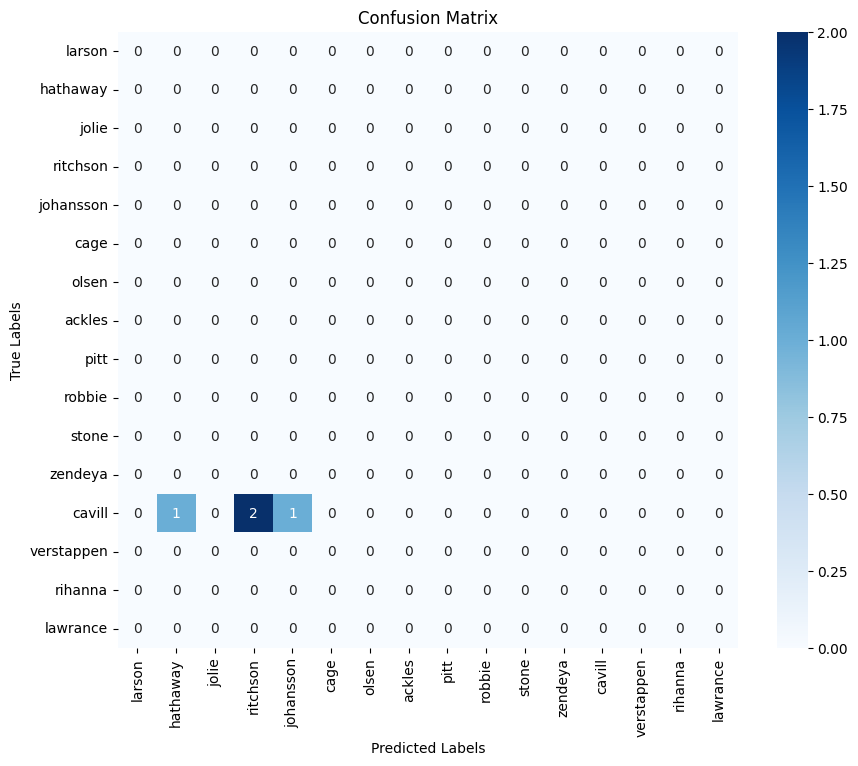

In [ ]:
# Call the evaluation function after your training loop
gallery_json_path = '/content/gallery_embeddings.json'
evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device)

In [ ]:
def evaluate_model_and_preditc(model, val_dataset, gallery_json_path, device, similarity_threshold=0.5):
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (validation set)
    model.eval()
    probe_embeddings = {}
    probe_labels = []
    with torch.no_grad():
        for images, person_labels, _ in DataLoader(val_dataset, batch_size=32, shuffle=False):
            images = images.to(device)
            embeddings, _, _ = model(images)
            for embedding, person_label in zip(embeddings, person_labels):
                person_name = val_dataset.index_to_person[person_label.item()]
                if person_name not in probe_embeddings:
                    probe_embeddings[person_name] = []
                probe_embeddings[person_name].append(embedding.cpu())
                probe_labels.append(person_name)

    print(f"Created probe embeddings: {len(probe_embeddings)} persons")
    total_val_images = sum(len(embeds) for embeds in probe_embeddings.values())
    print(f"Total validation images processed: {total_val_images}")

    # Ensure that we have the same number of images for validation and embedding creation
    all_probe_embeddings = []
    all_probe_labels = []
    for person_name, embeddings in probe_embeddings.items():
        all_probe_embeddings.extend(embeddings)
        all_probe_labels.extend([person_name] * len(embeddings))

    probe_tensors = torch.stack(all_probe_embeddings)
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    # Create a mapping from person names to indices
    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}

    # Add an "unknown" category
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    # Determine predicted labels and handle unknown faces
    predicted_indices = []
    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        person_name = all_probe_labels[i]
        print(f"Person: {person_name}, Max Similarity: {max_similarity}")
        if max_similarity < similarity_threshold:
            predicted_indices.append(unknown_idx)  # Use unknown index for unknown person
            if person_name not in loaded_gallery_embeddings:
                print(f"Adding {person_name} to gallery")
                loaded_gallery_embeddings[person_name] = [probe_tensors[i]]
                person_to_idx[person_name] = len(person_to_idx)
                idx_to_person[len(idx_to_person)] = person_name
        else:
            predicted_indices.append(torch.argmax(similarities).item())

    # True indices based on the probe set
    true_indices = []
    for person_name in all_probe_labels:
        if person_name in person_to_idx:
            person_idx = person_to_idx[person_name]
        else:
            person_idx = unknown_idx
        true_indices.append(person_idx)

    # Save updated gallery
    save_gallery_to_json(loaded_gallery_embeddings, gallery_json_path)
    print(f"Updated gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    if len(predicted_indices) != len(true_indices):
        print(f"Warning: Length mismatch - Predicted: {len(predicted_indices)}, True: {len(true_indices)}")
        min_length = min(len(predicted_indices), len(true_indices))
        predicted_indices = predicted_indices[:min_length]
        true_indices = true_indices[:min_length]

    accuracy = (torch.tensor(predicted_indices) == torch.tensor(true_indices)).float().mean().item()
    print(f'Validation Set Accuracy: {accuracy:.4f}')

    # Visualization
    # Convert indices to person names
    true_labels = [idx_to_person[idx] for idx in true_indices]
    predicted_labels = [idx_to_person[idx] for idx in predicted_indices]




In [ ]:
evaluate_model_and_preditc(model, val_dataset, gallery_json_path, device)

Loaded gallery embeddings: 16 persons
Created probe embeddings: 4 persons
Total validation images processed: 240
Person: cavill, Max Similarity: 0.6776314973831177
Person: cavill, Max Similarity: 0.6796384453773499
Person: cavill, Max Similarity: 0.7524340748786926
Person: cavill, Max Similarity: 0.8298352956771851
Person: cavill, Max Similarity: 0.6299317479133606
Person: cavill, Max Similarity: 0.7177507281303406
Person: cavill, Max Similarity: 0.6472989916801453
Person: cavill, Max Similarity: 0.6118379831314087
Person: cavill, Max Similarity: 0.7414504885673523
Person: cavill, Max Similarity: 0.8251822590827942
Person: cavill, Max Similarity: 0.8482191562652588
Person: cavill, Max Similarity: 0.8106228113174438
Person: cavill, Max Similarity: 0.813180148601532
Person: cavill, Max Similarity: 0.8237370252609253
Person: cavill, Max Similarity: 0.8611686825752258
Person: cavill, Max Similarity: 0.8551312685012817
Person: cavill, Max Similarity: 0.86323082447052
Person: cavill, Max Sim

<ipython-input-96-a2c5e8beee8a>:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gallery_embeddings_encoded = {person: [encode_embedding(torch.tensor(embedding)) for embedding in embeddings]


Updated gallery embeddings: 16 persons
Validation Set Accuracy: 0.8083


In [ ]:
import torch
from torch.utils.data import DataLoader

def evaluate_test_set_write(model, test_dataset, gallery_json_path, device, output_json_path, similarity_threshold=0.5):
    """
    Evaluate the model on the test set and write predictions to a JSON file.

    Args:
    - model: The trained model to be evaluated.
    - test_dataset: The test dataset.
    - gallery_json_path: Path to the gallery embeddings JSON file.
    - device: Device to run the model on (e.g., 'cuda' or 'cpu').
    - output_json_path: Path to the output JSON file for predictions.
    - similarity_threshold: Threshold for similarity to consider a match.

    Returns:
    - predictions: List of tuples containing filename, embedding, and style.
    """
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (test set)
    model.eval()
    probe_embeddings = []
    filenames = []
    style_outputs_list = []

    with torch.no_grad():
        for images, paths in DataLoader(test_dataset, batch_size=32, shuffle=False):
            images = images.to(device)
            features, identity_outputs, style_outputs = model(images)
            for embedding, path, style_output in zip(features, paths, style_outputs):
                probe_embeddings.append(embedding.cpu())
                filenames.append(path)
                style_outputs_list.append(style_output.cpu())

    print(f"Created probe embeddings for {len(filenames)} images")

    # Generate predictions
    predictions = []
    probe_tensors = torch.stack(probe_embeddings)
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        if max_similarity < similarity_threshold:
            predicted_person = "unknown"
        else:
            predicted_person = idx_to_person[torch.argmax(similarities).item()]
        predicted_style = torch.argmax(style_outputs_list[i]).item()  # Predicting style

        predictions.append((filenames[i], probe_tensors[i], predicted_style))

    write_predictions_to_json(predictions, output_json_path)

    return predictions

# Usage
prediction_path = 'predictions.json'
evaluate_test_set_write(model, test_dataset, 'gallery_embeddings.json', device, prediction_path)


Loaded gallery embeddings: 16 persons
Created probe embeddings for 360 images


[('/content/drive/MyDrive/New_folder/test/KS44fY8FoQ.png',
  tensor([-0.1409, -0.1068, -0.1424,  ...,  0.4064, -0.1286,  0.2272]),
  0),
 ('/content/drive/MyDrive/New_folder/test/jZRRy4PTN4.png',
  tensor([-0.1015, -0.1290, -0.0258,  ...,  0.8649, -0.0942,  0.4838]),
  0),
 ('/content/drive/MyDrive/New_folder/test/pRvwhGeTvM.png',
  tensor([-0.1067, -0.1255, -0.0851,  ...,  0.9286, -0.0080,  0.3635]),
  0),
 ('/content/drive/MyDrive/New_folder/test/BEQPjszIO1.png',
  tensor([-0.1062,  0.0856, -0.0755,  ...,  0.4010, -0.0564,  0.2990]),
  0),
 ('/content/drive/MyDrive/New_folder/test/qcmj1ujypQ.png',
  tensor([-0.1103, -0.0016, -0.0854,  ...,  0.1076, -0.0757,  0.6612]),
  0),
 ('/content/drive/MyDrive/New_folder/test/PvtQe1fYLe.png',
  tensor([-0.1212, -0.1060, -0.1112,  ..., -0.1405, -0.1038,  0.0232]),
  0),
 ('/content/drive/MyDrive/New_folder/test/GDt8eVL7G9.png',
  tensor([-0.1604, -0.0751, -0.1016,  ...,  0.1299, -0.0734,  0.7692]),
  0),
 ('/content/drive/MyDrive/New_folder/test

# **Torch Summary**

In [ ]:
pip install torchinfo


In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary
from efficientnet_pytorch import EfficientNet

class MultiLabelModel(nn.Module):
    def __init__(self, num_classes_identity, num_classes_style):
        super(MultiLabelModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.fc_identity = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_identity)
        )
        self.fc_style = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_style)
        )

    def forward(self, x):
        features = self.backbone(x)
        identity_output = self.fc_identity(features)
        style_output = self.fc_style(features)
        return features, identity_output, style_output

# Number of classes for identity and style
num_classes_identity = 20
num_classes_style = 6

# Instantiate the model
model = MultiLabelModel(num_classes_identity, num_classes_style)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model summary
summary(model, input_size=(32, 3, 224, 224))


Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                  Output Shape              Param #
MultiLabelModel                                         [32, 1280]                --
├─EfficientNet: 1-1                                     [32, 1280]                --
│    └─Conv2dStaticSamePadding: 2-1                     [32, 32, 112, 112]        864
│    │    └─ZeroPad2d: 3-1                              [32, 3, 225, 225]         --
│    └─BatchNorm2d: 2-2                                 [32, 32, 112, 112]        (64)
│    └─MemoryEfficientSwish: 2-3                        [32, 32, 112, 112]        --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [32, 16, 112, 112]        (1,448)
│    │    └─MBConvBlock: 3-3                            [32, 24, 56, 56]          (6,004)
│    │    └─MBConvBlock: 3-4                            [32, 24, 56, 56]          (10,710)
│    │    └─MBConvBlock: 3-5             

#Introduction
In this project, I aimed to build a multi-label image classification model to recognize both the identity and style of celebrity cartoons. I used the EfficientNet architecture for state-of-the-art performance in image classification tasks. This report details the methods used, experiments and results obtained during the project.

# Methods


1.   Model Architecture
2.   Loss Function
3.   Training Strategies

## Model Architecture


I chose EfficientNet-B0 as the backbone for our model due to its balance between performance and computational efficiency. The model architecture is as follows:


```
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class MultiLabelModel(nn.Module):
    def __init__(self, num_classes_identity, num_classes_style):
        super(MultiLabelModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.fc_identity = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_identity)
        )
        self.fc_style = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_style)
        )

    def forward(self, x):
        features = self.backbone(x)
        identity_output = self.fc_identity(features)
        style_output = self.fc_style(features)
        return features, identity_output, style_output

```
## Loss Function

I used the Cross-Entropy Loss for both identity and style classification tasks. Additionally, a joint loss function was defined to combine these two losses:

```
criterion_identity = nn.CrossEntropyLoss()
criterion_style = nn.CrossEntropyLoss()

def joint_loss(identity_output, style_output, identity_labels, style_labels, weight=0.5):
    loss_identity = criterion_identity(identity_output, identity_labels)
    loss_style = criterion_style(style_output, style_labels)
    return weight * loss_identity + (1 - weight) * loss_style

```

## Training Strategies
I employed the Adam optimizer with a higher weight decay to prevent overfitting and a lower learning rate for more stable convergence. An early stopping mechanism was implemented to halt training when no improvement was observed over several epochs.

```
optimizer = optim.Adam([
    {'params': model.fc_identity.parameters()},
    {'params': model.fc_style.parameters()}
], lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

```


# Conclusion

In this project, I successfully implemented a multi-label image classification model using EfficientNet. The model demonstrated high accuracy in recognizing both the identity and style of celebrity caricatures.

# References


*   https://paperswithcode.com/method/efficientnet
*   https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/
*https://medium.com/@aniketthomas27/efficientnet-implementation-from-scratch-in-pytorch-a-step-by-step-guide-a7bb96f2bdaa
* Thanks to EFE İLHAN, FAHRETTİN EGE BİLGE, BAHADIR ERDEM AND BARIŞ NİŞANCI
